# Hotel Booking Binary Classification Analysis

This notebook performs a comprehensive analysis and binary classification on hotel booking data to predict booking status (Canceled vs Not_Canceled).

## Tasks to Complete:
1. Data Preprocessing (Check Null, Data Type, Format validation, Remove Booking_ID column, convert date of reservation from object to date data type)
2. Outlier Detection and Handling (IQR/Z-Score)
3. Feature Engineering (Selection & Extraction)
4. Check for Multicollinearity and solve it if found
5. Principal Component Analysis (PCA) for Dimensionality Reduction
6. Categorical Data Transformation
7. Train-Test Split
8. Modeling and Accuracy Calculation

**Target Variable:** booking status (Binary Classification: Canceled vs Not_Canceled)

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Statistical libraries
from scipy import stats
from scipy.stats import zscore

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [62]:
# Load the dataset
df = pd.read_csv('first intern project.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (36285, 17)

First 5 rows:


,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [63]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("Dataset Description:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float

Target Variable Distribution:
booking status
Not_Canceled    24396
Canceled        11889
Name: count, dtype: int64

Target Variable Proportions:
booking status
Not_Canceled    0.672344
Canceled        0.327656
Name: proportion, dtype: float64


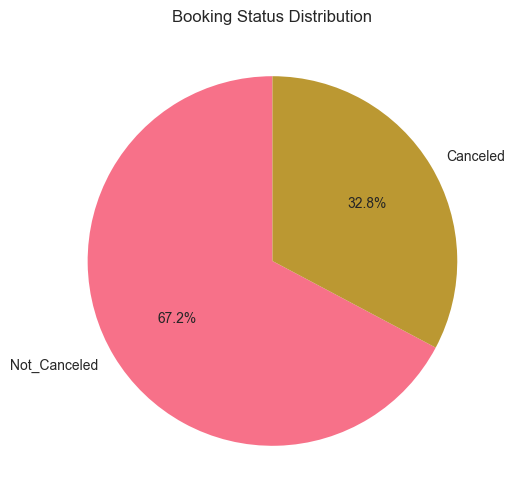

In [64]:
# Check the target variable distribution
print("Target Variable Distribution:")
print(df['booking status'].value_counts())
print("\nTarget Variable Proportions:")
print(df['booking status'].value_counts(normalize=True))

# Simple pie chart visualization
plt.figure(figsize=(8, 6))
values = df['booking status'].value_counts()
plt.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90)
plt.title('Booking Status Distribution')
plt.show()

## 2. Data Preprocessing

### 2.1 Check for Null Values

In [65]:
# Check for null values
print("Null values in dataset:")
print(df.isnull().sum())
print(f"\nTotal null values: {df.isnull().sum().sum()}")

# Drop rows with any null values (simple approach)
df_clean = df.dropna()
print(f"Shape after removing nulls: {df_clean.shape}")

Null values in dataset:
Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

Total null values: 0
Shape after removing nulls: (36285, 17)


### 2.2 Data Types Analysis

In [66]:
# Check data types
print("Data types:")
print(df_clean.dtypes)

# Convert date of reservation from object to datetime (handles mixed formats)
df_clean['date of reservation'] = pd.to_datetime(df_clean['date of reservation'], format='mixed', errors='coerce')
print(f"\nDate column converted to: {df_clean['date of reservation'].dtype}")
print(f"Number of unparsable dates (NaT): {df_clean['date of reservation'].isna().sum()}")


Data types:
Booking_ID                   object
number of adults              int64
number of children            int64
number of weekend nights      int64
number of week nights         int64
type of meal                 object
car parking space             int64
room type                    object
lead time                     int64
market segment type          object
repeated                      int64
P-C                           int64
P-not-C                       int64
average price               float64
special requests              int64
date of reservation          object
booking status               object
dtype: object

Date column converted to: datetime64[ns]
Number of unparsable dates (NaT): 37


In [67]:
df_clean.dtypes

Booking_ID                          object
number of adults                     int64
number of children                   int64
number of weekend nights             int64
number of week nights                int64
type of meal                        object
car parking space                    int64
room type                           object
lead time                            int64
market segment type                 object
repeated                             int64
P-C                                  int64
P-not-C                              int64
average price                      float64
special requests                     int64
date of reservation         datetime64[ns]
booking status                      object
dtype: object

### 2.3 Data Format Validation and Cleaning

In [68]:
# Validate and clean data formats for each column in df_clean

# Standardize column names to avoid KeyError due to extra spaces
df_clean.columns = df_clean.columns.str.strip()

# Drop 'Booking_ID' column if present
if 'Booking_ID' in df_clean.columns:
    df_clean = df_clean.drop('Booking_ID', axis=1)
    print("'Booking_ID' column dropped.")

# 1. Check for any remaining nulls after date conversion
print("Null values after date conversion:")
print(df_clean.isnull().sum())

# 2. Remove rows with NaT in 'date of reservation' (if any)
df_clean = df_clean[df_clean['date of reservation'].notna()]
print(f"Shape after removing rows with invalid dates: {df_clean.shape}")

# 3. Check for duplicates
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Shape after removing duplicates: {df_clean.shape}")

# 4. Validate numeric columns for negative or illogical values
numeric_cols = [
    'number of adults', 'number of children', 'number of weekend nights',
    'number of week nights', 'car parking space', 'lead time',
    'repeated', 'P-C', 'P-not-C', 'average price', 'special requests'
]
for col in numeric_cols:
    if col in df_clean.columns:
        invalid = (df_clean[col] < 0).sum()
        if invalid > 0:
            print(f"Warning: {invalid} negative values found in '{col}'")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# 5. Check unique values in categorical columns
categorical_cols = ['type of meal', 'room type', 'market segment type', 'booking status']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"Unique values in '{col}': {df_clean[col].unique()}")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

'Booking_ID' column dropped.
Null values after date conversion:
number of adults             0
number of children           0
number of weekend nights     0
number of week nights        0
type of meal                 0
car parking space            0
room type                    0
lead time                    0
market segment type          0
repeated                     0
P-C                          0
P-not-C                      0
average price                0
special requests             0
date of reservation         37
booking status               0
dtype: int64
Shape after removing rows with invalid dates: (36248, 16)
Number of duplicate rows: 10274
Shape after removing duplicates: (25974, 16)
Unique values in 'type of meal': ['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']
Unique values in 'room type': ['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
Unique values in 'market segment type': ['Offline' 'Online' 'Corporat

## 3. Outlier Detection and Handling

### 3.1 Outlier Detection using IQR Method

In [69]:
df_clean.select_dtypes(include=[np.number]).columns.tolist()

['number of adults',
 'number of children',
 'number of weekend nights',
 'number of week nights',
 'car parking space',
 'lead time',
 'repeated',
 'P-C',
 'P-not-C',
 'average price',
 'special requests']

In [70]:
# IQR Method for Outlier Detection
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} outliers")

number of adults: 7119 outliers
number of children: 2578 outliers
number of weekend nights: 21 outliers
number of week nights: 299 outliers
car parking space: 1092 outliers
lead time: 815 outliers
repeated: 848 outliers
P-C: 268 outliers
P-not-C: 797 outliers
average price: 1077 outliers
special requests: 680 outliers


### 3.2 Outlier Detection using Z-Score Method

In [71]:
# Z-Score Method for Outlier Detection (threshold = 3)
for col in numeric_cols:
    z_scores = np.abs(zscore(df_clean[col]))
    outliers = (z_scores > 3).sum()
    print(f"{col}: {outliers} outliers")

number of adults: 151 outliers
number of children: 1052 outliers
number of weekend nights: 167 outliers
number of week nights: 299 outliers
car parking space: 1092 outliers
lead time: 378 outliers
repeated: 848 outliers
P-C: 137 outliers
P-not-C: 229 outliers
average price: 225 outliers
special requests: 79 outliers


### 3.3 Outlier Visualization

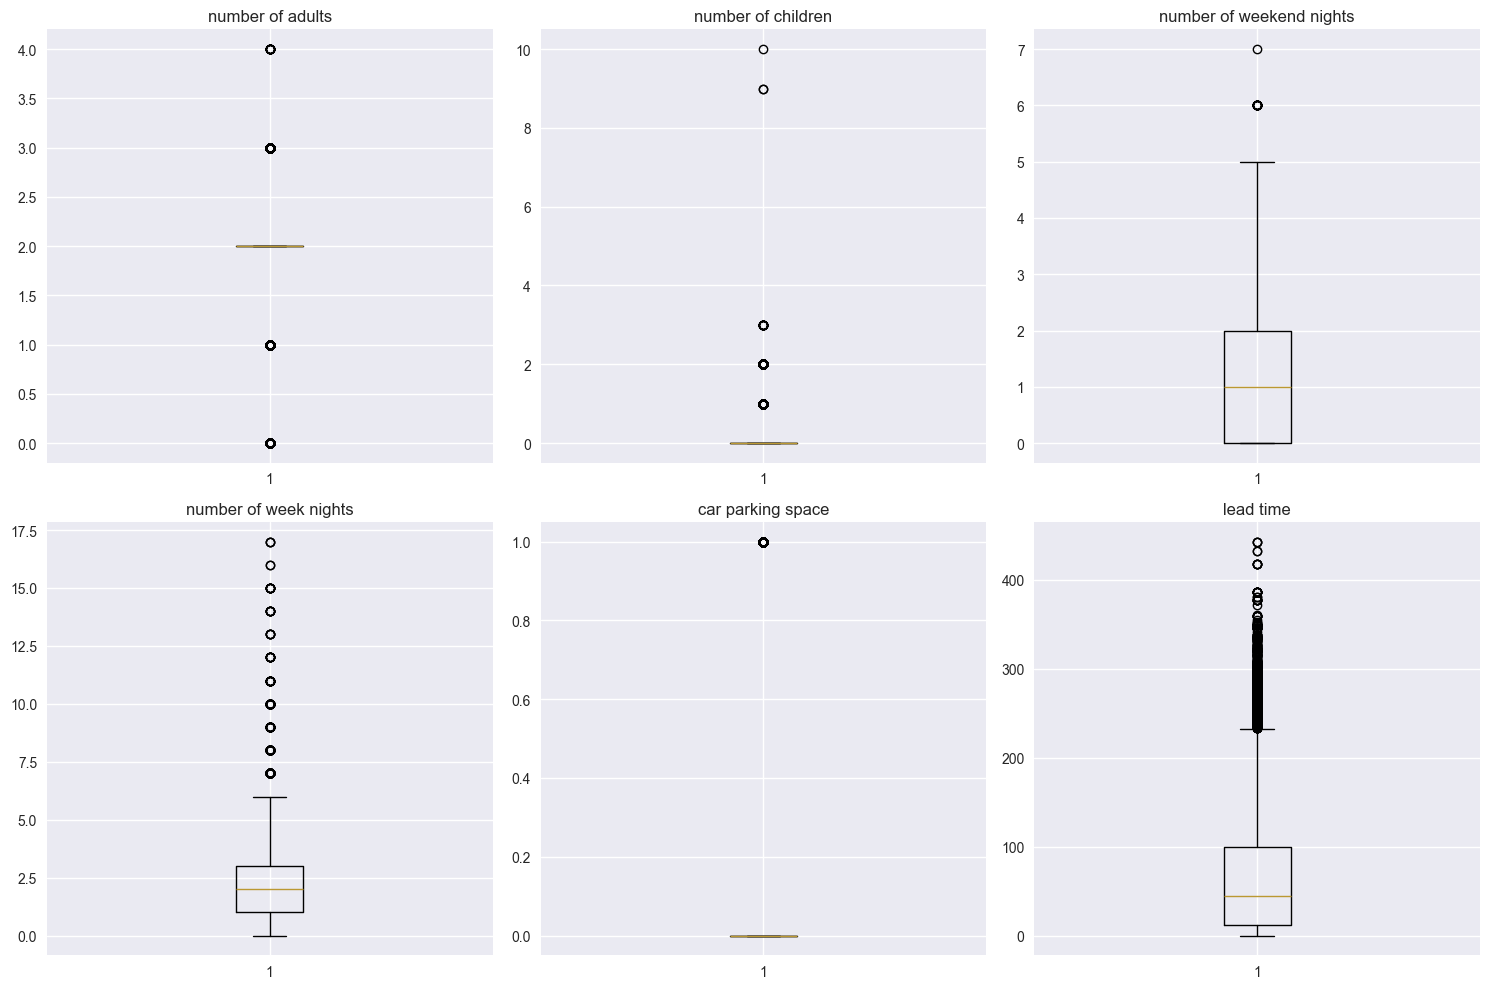

In [72]:
# Simple Boxplot Visualization for Outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6], 1):  # Show first 6 numeric columns
    plt.subplot(2, 3, i)
    plt.boxplot(df_clean[col])
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

### 3.4 Outlier Handling

In [73]:
# Remove Outliers using IQR Method (simple approach)
df_no_outliers = df_clean.copy()

for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

print(f"Original shape: {df_clean.shape}")
print(f"After removing outliers: {df_no_outliers.shape}")
print(f"Rows removed: {df_clean.shape[0] - df_no_outliers.shape[0]}")

Original shape: (25974, 16)
After removing outliers: (14439, 16)
Rows removed: 11535


## 4. Feature Engineering

### 4.1 Feature Creation and Extraction

In [74]:
# Simple Feature Creation
df_features = df_no_outliers.copy()

# Create new features from existing ones
df_features['total_nights'] = df_features['number of weekend nights'] + df_features['number of week nights']
df_features['total_guests'] = df_features['number of adults'] + df_features['number of children']
df_features['price_per_night'] = df_features['average price'] / (df_features['total_nights'] + 1)  # +1 to avoid division by zero

print("New features created:")
print("- total_nights, total_guests, price_per_night")

New features created:
- total_nights, total_guests, price_per_night


### 4.2 Feature Selection

In [75]:
# Simple Feature Selection - Remove irrelevant columns
columns_to_drop = ['date of reservation']  # Date column not useful for most ML models
df_features = df_features.drop(columns_to_drop, axis=1)

print(f"Columns after feature selection: {df_features.shape[1]}")
print(f"Remaining columns: {list(df_features.columns)}")

Columns after feature selection: 18
Remaining columns: ['number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'type of meal', 'car parking space', 'room type', 'lead time', 'market segment type', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'booking status', 'total_nights', 'total_guests', 'price_per_night']


### 4.3 Check Multicollinearity

In [76]:
# Check Multicollinearity - Simple Correlation Matrix
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_features[numeric_features].corr()

# Find high correlations (>0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr) if x != y and x < y]

print("High correlation pairs (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

High correlation pairs (>0.8):
number of week nights - total_nights: 0.843


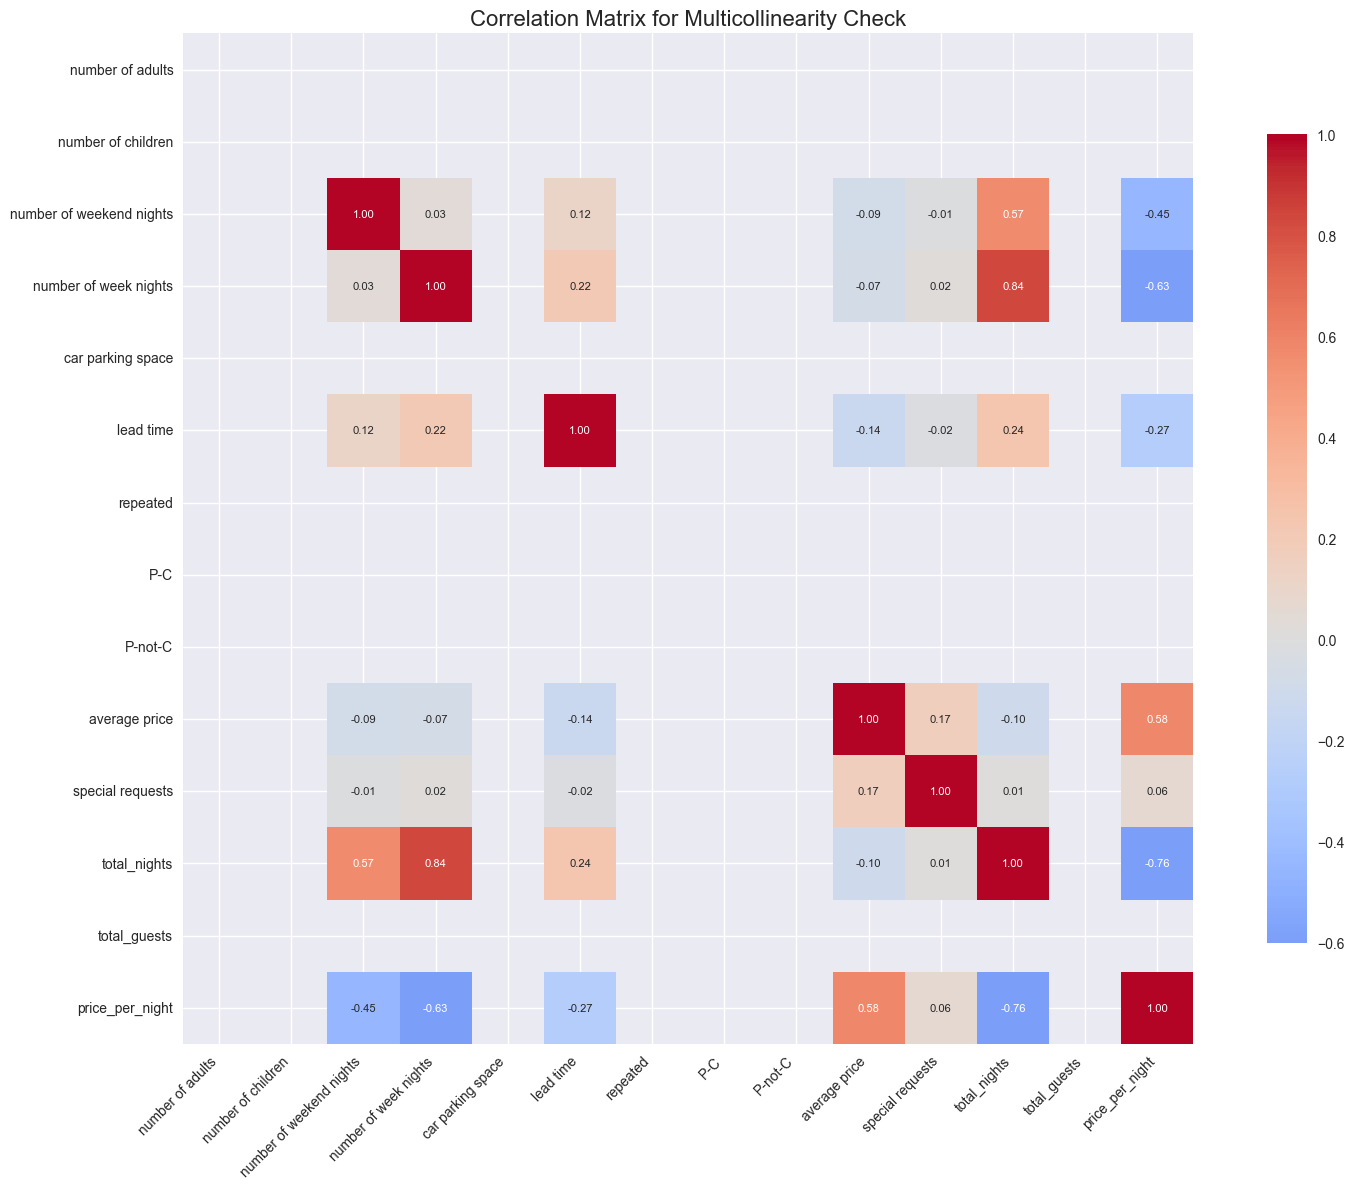

In [86]:

# Plot the heatmap
plt.figure(figsize=(16, 12))  # Adjust to (16, 12) if crowded
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8},
            vmin=-0.6, vmax=1.0)
plt.title('Correlation Matrix for Multicollinearity Check', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.4 Principal Component Analysis (PCA) for Dimensionality Reduction

In [92]:
# Simple PCA for Dimensionality Reduction 
from sklearn.decomposition import PCA

# Separate numeric features for PCA
numeric_data = df_features[numeric_features]
pca = PCA(n_components=0.95)  # Keep 95% of variance
numeric_pca = pca.fit_transform(numeric_data)

print(f"Original numeric features: {numeric_data.shape[1]}")
print(f"PCA components: {numeric_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# note: i will not use PCA in this notebook, but it is a good practice to keep it for future reference

Original numeric features: 14
PCA components: 2
Variance explained: 0.972


In [93]:
# Simplest approach - Remove one feature from each highly correlated pair
features_to_remove = []

# From your high correlation pairs, manually choose which to remove
correlation_decisions = {
    # If you have these pairs, remove the less important one:
    # 'total_nights': 'number of weekend nights',  # Remove total_nights, keep original
    # 'total_guests': 'number of adults',          # Remove total_guests, keep original
    # Add more based on your actual high correlation pairs
}

# Remove highly correlated features
for pair in high_corr_pairs:
    feature1, feature2 = pair[0], pair[1]
    
    # Simple rule: remove the feature that appears later alphabetically
    # (you can customize this logic)
    if feature1 not in features_to_remove and feature2 not in features_to_remove:
        if feature1 > feature2:  # Alphabetical comparison
            features_to_remove.append(feature1)
        else:
            features_to_remove.append(feature2)

# Apply feature removal
df_final = df_features[numeric_features].drop(columns=features_to_remove)

print(f"Removed features: {features_to_remove}")
print(f"Final features: {list(df_final.columns)}")
print(f"Reduced from {len(numeric_features)} to {len(df_final.columns)} features")

# Update for next steps
numeric_features_final = df_final.columns.tolist()

Removed features: ['total_nights']
Final features: ['number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'car parking space', 'lead time', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'total_guests', 'price_per_night']
Reduced from 14 to 13 features


## 5. Categorical Data Transformation

In [94]:
# Simple Categorical Data Transformation
# Identify categorical columns
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Label encode target variable
le_target = LabelEncoder()
df_features['booking_status_encoded'] = le_target.fit_transform(df_features['booking status'])
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# One-hot encode other categorical features
categorical_features = [col for col in categorical_cols if col != 'booking status']
df_encoded = pd.get_dummies(df_features, columns=categorical_features, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"New columns created: {df_encoded.shape[1] - df_features.shape[1]}")

Categorical columns: ['type of meal', 'room type', 'market segment type', 'booking status']
Target encoding: {'Canceled': np.int64(0), 'Not_Canceled': np.int64(1)}
Shape after encoding: (14439, 28)
New columns created: 9


In [95]:
df_encoded.head()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests,booking status,total_nights,total_guests,price_per_night,booking_status_encoded,type of meal_Meal Plan 2,type of meal_Not Selected,room type_Room_Type 2,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
12,2,0,2,1,0,30,0,0,0,88.0,0,Canceled,3,2,22.0,0,False,True,False,False,False,False,False,False,False,False,False,True
14,2,0,0,2,0,47,0,0,0,94.5,2,Not_Canceled,2,2,31.5,1,False,False,False,False,False,False,False,False,False,False,False,True
17,2,0,1,3,0,1,0,0,0,96.0,1,Not_Canceled,4,2,19.2,1,False,True,False,False,False,False,False,False,False,False,False,True
18,2,0,2,2,0,99,0,0,0,65.0,0,Canceled,4,2,13.0,0,False,False,False,False,False,False,False,False,False,False,False,True
19,2,0,1,0,0,12,0,0,0,72.0,0,Not_Canceled,1,2,36.0,1,False,False,False,False,False,False,False,False,False,False,True,False


## 6. Final Feature Selection and Data Preparation

In [110]:
# Final Feature Selection and Data Preparation (CORRECTED)
# Separate target variable
y = df_encoded['booking_status_encoded']

# Get only the features we want (numeric + encoded categorical)
numeric_cols_final = [col for col in numeric_features_final if col in df_encoded.columns]
categorical_encoded_cols = [col for col in df_encoded.columns if col not in df_features.columns]

# Prepare final feature set
X = df_encoded[numeric_cols_final + categorical_encoded_cols]

# Scale numerical features only
scaler = StandardScaler()
X[numeric_cols_final] = scaler.fit_transform(X[numeric_cols_final])

print(f"Final dataset shape: {X.shape}")
print(f"Numeric features: {len(numeric_cols_final)}")
print(f"Encoded categorical features: {len(categorical_encoded_cols)}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print("Data preparation completed! ✅")

Final dataset shape: (14439, 25)
Numeric features: 13
Encoded categorical features: 12
Target distribution: {1: 10237, 0: 4202}
Data preparation completed! ✅


In [112]:
# Quick verification of final dataset
print("=== FINAL DATASET VERIFICATION ===")
print(f"Feature names: {list(X.columns)}")
print(f"Data types:\n{X.dtypes.value_counts()}")
print(f"Any nulls: {X.isnull().sum().sum()}")
print("✅ Dataset ready for train-test split!")

=== FINAL DATASET VERIFICATION ===
Feature names: ['number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'car parking space', 'lead time', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'total_guests', 'price_per_night', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 2', 'room type_Room_Type 3', 'room type_Room_Type 4', 'room type_Room_Type 5', 'room type_Room_Type 6', 'room type_Room_Type 7', 'market segment type_Complementary', 'market segment type_Corporate', 'market segment type_Offline', 'market segment type_Online']
Data types:
float64    13
bool       12
Name: count, dtype: int64
Any nulls: 0
✅ Dataset ready for train-test split!


## 7. Train-Test Split

In [114]:
# Simple Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")
print("✅ Train-test split completed!")

Training set shape: (11551, 25)
Test set shape: (2888, 25)
Training target distribution: {1: 8189, 0: 3362}
Test target distribution: {1: 2048, 0: 840}
✅ Train-test split completed!


## 8. Modeling and Accuracy Calculation

### 8.1 Model Training and Evaluation

In [115]:
# Simple Model Training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name}: {accuracy:.4f}")

print("✅ Model training completed!")

Logistic Regression: 0.7929
Random Forest: 0.7940
Random Forest: 0.7940
Gradient Boosting: 0.8227
Gradient Boosting: 0.8227
SVM: 0.8096
✅ Model training completed!
SVM: 0.8096
✅ Model training completed!


### 8.2 Model Comparison

Model Rankings:
Gradient Boosting: 0.8227
SVM: 0.8096
Random Forest: 0.7940
Logistic Regression: 0.7929

Best Model: Gradient Boosting (0.8227)


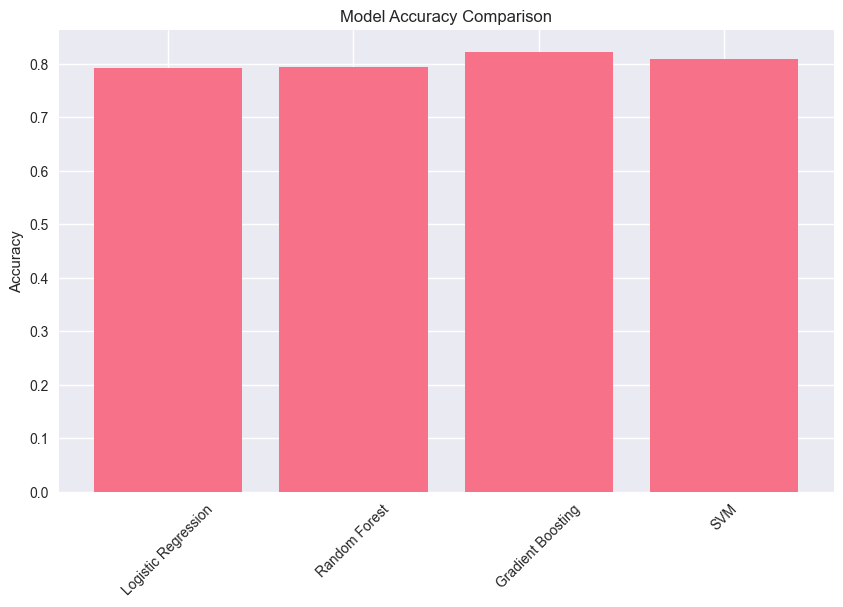

In [116]:
# Simple Model Comparison
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

print("Model Rankings:")
for model, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {accuracy:.4f}")

print(f"\nBest Model: {best_model} ({best_accuracy:.4f})")

# Simple bar plot
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

### 8.3 Best Model Analysis

Best Model: Gradient Boosting
Accuracy: 0.8227

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.58      0.66       840
           1       0.84      0.92      0.88      2048

    accuracy                           0.82      2888
   macro avg       0.80      0.75      0.77      2888
weighted avg       0.82      0.82      0.82      2888



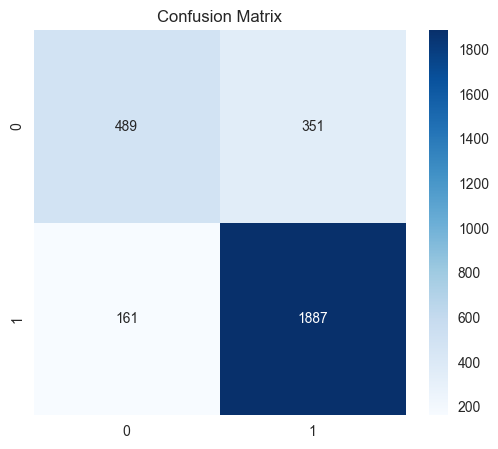

In [117]:
# Simple Best Model Analysis
best_model_obj = models[best_model]
y_pred_best = best_model_obj.predict(X_test)

print(f"Best Model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Simple confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### 8.4 ROC Curve Analysis

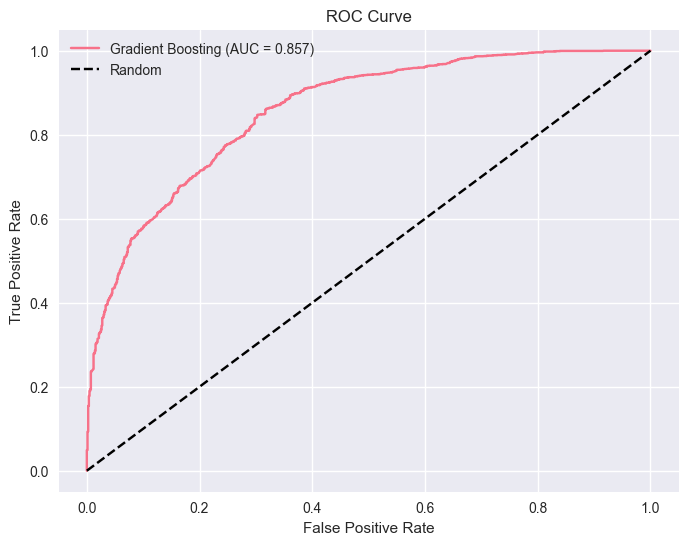

AUC Score: 0.8569


In [118]:
# Simple ROC Curve Analysis
y_proba = best_model_obj.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model} (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.4f}")

### 8.5 Feature Importance Analysis

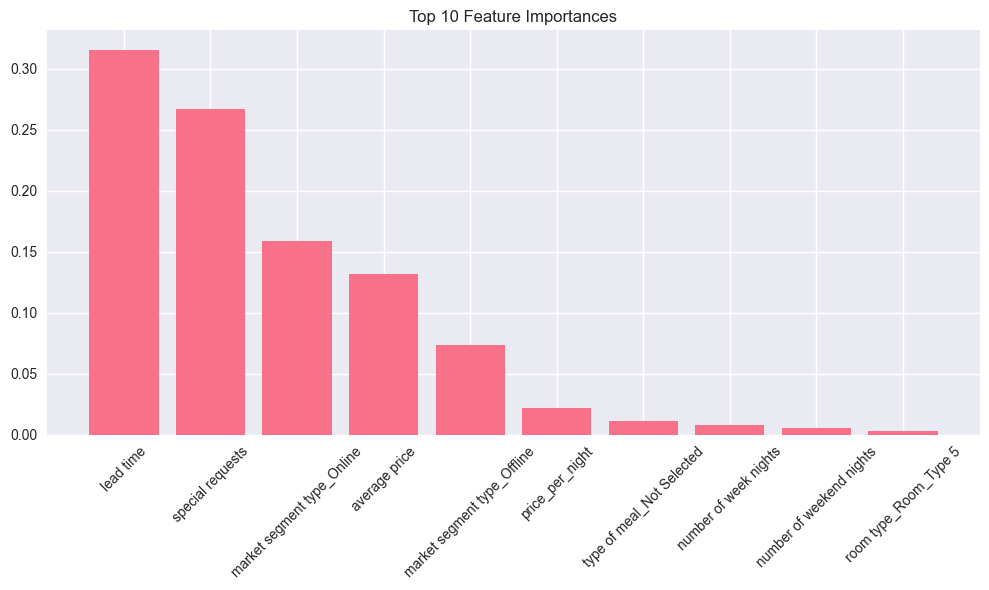

Top 10 Important Features:
1. lead time: 0.3157
2. special requests: 0.2669
3. market segment type_Online: 0.1591
4. average price: 0.1316
5. market segment type_Offline: 0.0733
6. price_per_night: 0.0220
7. type of meal_Not Selected: 0.0111
8. number of week nights: 0.0078
9. number of weekend nights: 0.0054
10. room type_Room_Type 5: 0.0030


In [119]:
# Simple Feature Importance Analysis
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
    feature_names = X.columns
    
    # Get top 10 features
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Important Features:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    print("Feature importance not available for this model type")

## 9. Final Summary and Insights

In [120]:
# Simple Final Summary
print("HOTEL BOOKING BINARY CLASSIFICATION - SUMMARY")
print("=" * 50)
print(f"Dataset Shape: {X.shape}")
print(f"Best Model: {best_model}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

print("\nAll Model Results:")
for model, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {accuracy:.4f}")

print("\n✅ Binary Classification Analysis Completed!")
print("=" * 50)

HOTEL BOOKING BINARY CLASSIFICATION - SUMMARY
Dataset Shape: (14439, 25)
Best Model: Gradient Boosting
Best Accuracy: 0.8227
AUC Score: 0.8569

All Model Results:
  Gradient Boosting: 0.8227
  SVM: 0.8096
  Random Forest: 0.7940
  Logistic Regression: 0.7929

✅ Binary Classification Analysis Completed!
